## Imports

In [1]:
%reload_ext watermark
%reload_ext autoreload
%autoreload 2
%watermark -v -p numpy,sklearn,pandas
%watermark -v -p cv2,PIL,matplotlib
%watermark -v -p torch,torchvision,torchaudio
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.use_jedi = False

from IPython.display import display, Markdown, HTML, Javascript
display(HTML('<style>.container { width:%d%% !important; }</style>' % 80))

import sys, os, io, time, random, math
import json, base64, requests
import os.path as osp

def _IMPORT_(x):
    try:
        segs = x.split(' ')
        g = globals()
        if 'github.com' in segs[1]:
            uri = segs[1].replace('github.com', 'raw.githubusercontent.com')
            mod = uri.split('/')
            uri = 'https://' + '/'.join(mod[:-1]) + '/main/' + mod[-1] + '.py'
            x = requests.get(uri).text
        elif 'gitee.com' in segs[1]:
            mod = segs[1].split('/')
            uri = 'https://' + '/'.join(mod[:-1]) + '/raw/main/' + mod[-1] + '.py'
            x = requests.get(uri).text
        elif segs[1][0] == '/':
            with open(segs[1] + '.py') as fr:
                x = fr.read()
        exec(x, g)
    except:
        pass

def print_progress_bar(x):
    print('\r', end='')
    print('Progress: {}%:'.format(x), '%s%s' % ('▋'*(x//2), '.'*((100-x)//2)), end='')
    sys.stdout.flush()

def img2b64(x):
    if isinstance(x, bytes):
        return base64.b64encode(x).decode()
    elif isinstance(x, str):
        with open(x, 'rb') as fr:
            return base64.b64encode(fr.read()).decode()
    raise


CPython 3.6.9
IPython 7.16.1

numpy 1.19.4
sklearn 0.24.0
pandas 1.1.5
CPython 3.6.9
IPython 7.16.1

cv2 4.5.1
PIL 6.2.2
matplotlib 3.3.3
CPython 3.6.9
IPython 7.16.1

torch 1.8.0.dev20210103+cu101
torchvision 0.9.0.dev20210103+cu101
torchaudio not installed


In [2]:
###
### Common ###
###

_IMPORT_('import numpy as np')
_IMPORT_('import pandas as pd')
_IMPORT_('from tqdm.notebook import tqdm')

###
### Display ###
###

_IMPORT_('import cv2')
_IMPORT_('from PIL import Image, ImageDraw, ImageFilter, ImageColor')
_IMPORT_('from torchvision.utils import make_grid')
_IMPORT_('import matplotlib.pyplot as plt')
_IMPORT_('import plotly')
_IMPORT_('import plotly.graph_objects as go')
_IMPORT_('import ipywidgets as widgets')

# plotly.offline.init_notebook_mode(connected=False)

plt.rcParams['figure.figsize'] = (12.0, 8.0)

def show_table(headers, data, width=900):
    ncols = len(headers)
    width = int(width / ncols)
    lralign = []
    caption = []
    for item in headers:
        astr = ''
        if item[0] == ':':
            astr = ':'
            item = item[1:]
        astr += '---'
        if item[-1] == ':':
            astr += ':'
            item = item[:-1]
        lralign.append(astr)
        caption.append(item)
    captionstr = '|'.join(caption) + chr(10)
    lralignstr = '|'.join(lralign) + chr(10)
    imgholdstr = '|'.join(['<img width=%d/>' % width] * ncols) + chr(10)
    table = captionstr + lralignstr + imgholdstr
    is_dict = isinstance(data[0], dict)
    for row in data:
        if is_dict:
            table += '|'.join([f'{row[c]}' for c in caption]) + chr(10)
        else:
            table += '|'.join([f'{col}' for col in row]) + chr(10)
    return Markdown(table)

def show_video(vidsrc, width=None, height=None):
    W, H = '', ''
    if width:
        W = 'width=%d' % width
    if height:
        H = 'height=%d' % height
    if vidsrc.startswith('http'):
        data_url = vidsrc
    else:
        mp4 = open(vidsrc, 'rb').read()
        data_url = 'data:video/mp4;base64,' + base64.b64encode(mp4).decode()
    return HTML('<video %s %s controls src="%s" type="video/mp4"/>' % (W, H, data_url))

def show_image(imgsrc, width=None, height=None):
    if isinstance(imgsrc, np.ndarray):
        img = imgsrc
        if width or height:
            if width and height:
                size = (width, height)
            else:
                rate = img.shape[1] / img.shape[0]
                if width:
                    size = (width, int(width/rate))
                else:
                    size = (int(height*rate), height)
            img = cv2.resize(img, size)
            plt.figure(figsize=(3*int(size[0]/80+1), 3*int(size[1]/80+1)), dpi=80)
        plt.axis('off')
        if len(img.shape) > 2:
            plt.imshow(img);
        else:
            plt.imshow(img, cmap='gray');
        return
    elif isinstance(imgsrc, Image.Image):
        display(imgsrc)
        return

    W, H = '', ''
    if width:
        W = 'width=%d' % width
    if height:
        H = 'height=%d' % height
    if imgsrc.startswith('http'):
        data_url = imgsrc
    else:
        if len(imgsrc) > 2048:
            data_url = 'data:image/jpg;base64,' + imgsrc
        else:
            img = open(imgsrc, 'rb').read()
            data_url = 'data:image/jpg;base64,' + base64.b64encode(img).decode()
    return HTML('<img %s %s src="%s"/>' % (W, H, data_url))

    W, H = '', ''
    if width:
        W = 'width=%d' % width
    if height:
        H = 'height=%d' % height
    if image_path.startswith('http'):
        data_url = image_path
    else:
        img = open(image_path, 'rb').read()
        data_url = 'data:image/jpg;base64,' + base64.b64encode(img).decode()
    return HTML('<img %s %s src="%s"/>' % (W, H, data_url))

def im_read(url, rgb=True, size=None):
    if url.startswith('http'):
        response = requests.get(url)
        if response:
            imgmat = np.frombuffer(response.content, dtype=np.uint8)
            img = cv2.imdecode(imgmat, cv2.IMREAD_COLOR)
        else:
            return None
    else:
        img = cv2.imread(url)
        
    if rgb:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if size:
        if isinstance(size, int):
            size = (size, size)
        img = cv2.resize(img, size, interpolation=cv2.INTER_AREA)
    return img


## 橘子案例

In [3]:
width = 250
height = 250
fruit_color_range = [[180,230],[50,130],[0,5]]

In [4]:
def prepare_colors():
    txt_leaves = [
        '#608d2a', '#a8b146', '#ccf0bc', '#aace57', '#2e5d0b', '#071d06', '#71a476', '#3a4533', 
        '#759a65', '#25321f', '#59734d', '#90ab64', '#7b8554', '#7b8554', '#4d5430']
    txt_sky = ['#e9e3c3', '#99949e', '#9bb5cf' , '#f6fbfb', '#91959b', '#c0e1f9', '#dd9b98', '#dd9b98', '#deb29f']
    txt_ground = ['#3d2c15', '#dfcba6', '#8d6e42', '#c99276', '#655223', '#dfd1c1', '#f5c9ae', '#9a8149']

    bg_colors = []
    fg_colors = []

    for t in txt_leaves:
        bg_colors.append(ImageColor.getrgb(t))
        fg_colors.append(ImageColor.getrgb(t))
    for t in txt_sky:
        bg_colors.append(ImageColor.getrgb(t))
    for t in txt_ground:
        bg_colors.append(ImageColor.getrgb(t))
    return bg_colors, fg_colors

In [5]:
def plot_random_blobs(draw, colors, count, mins, maxs):
    for i in range(count):
        x = random.randint(0, width)
        y = random.randint(0, height)
        w = random.randint(mins, maxs)
        l = random.randint(mins, maxs)
        c = colors[random.randint(0,len(colors) - 1)]
        draw.ellipse((x, y, x + w, y + l), fill=c, outline=None)

In [6]:
def create_bg(colors, width, height):
    im_bg = Image.new('RGBA', (width, height), ImageColor.getrgb('#7FCBFDFF'))
    draw_bg = ImageDraw.Draw(im_bg)
    plot_random_blobs(draw_bg, colors, 1500, 10, 25)
    im_bg = im_bg.filter(ImageFilter.MedianFilter(size=9))
    return im_bg

def create_fg(colors, width, height):
    im_fg = Image.new('RGBA', (width, height), (0, 0, 0, 0))
    draw_fg = ImageDraw.Draw(im_fg)
    plot_random_blobs(draw_fg, colors, 40, 10, 25)
    im_fg = im_fg.filter(ImageFilter.MedianFilter(size=9))
    return im_fg

In [7]:
def plot_random_fruit(color_range, count, width, height, mins, maxs):
    im_fruit = Image.new('RGBA', (width, height), (0, 0, 0, 0))
    draw_fruit = ImageDraw.Draw(im_fruit)

    fruit_info = []
    for i in range(count):
        x = random.randint(0, width-10)
        y = random.randint(0, height-10)
        w = random.randint(mins, maxs)
        c = (random.randint(color_range[0][0],color_range[0][1]),
            random.randint(color_range[1][0], color_range[1][1]),
            random.randint(color_range[2][0], color_range[2][1]))
        fruit_info.append([x, y, w, w, c])
        draw_fruit.ellipse((x, y, x+w, y+w), fill=c, outline=None)
    return im_fruit, fruit_info

In [8]:
fruit_count = random.randint(0, 20)
bg_colors, fg_colors = prepare_colors()
im_bg = create_bg(bg_colors, width, height)
im_fg = create_fg(fg_colors, width, height)
im_fruit, fruit_info = plot_random_fruit(fruit_color_range, fruit_count, width, height, 10, 25)

In [9]:
im_combine = im_bg.copy()
im_combine.paste(im_fruit, (0, 0), im_fruit)
im_combine.paste(im_fg, (0, 0), im_fg)

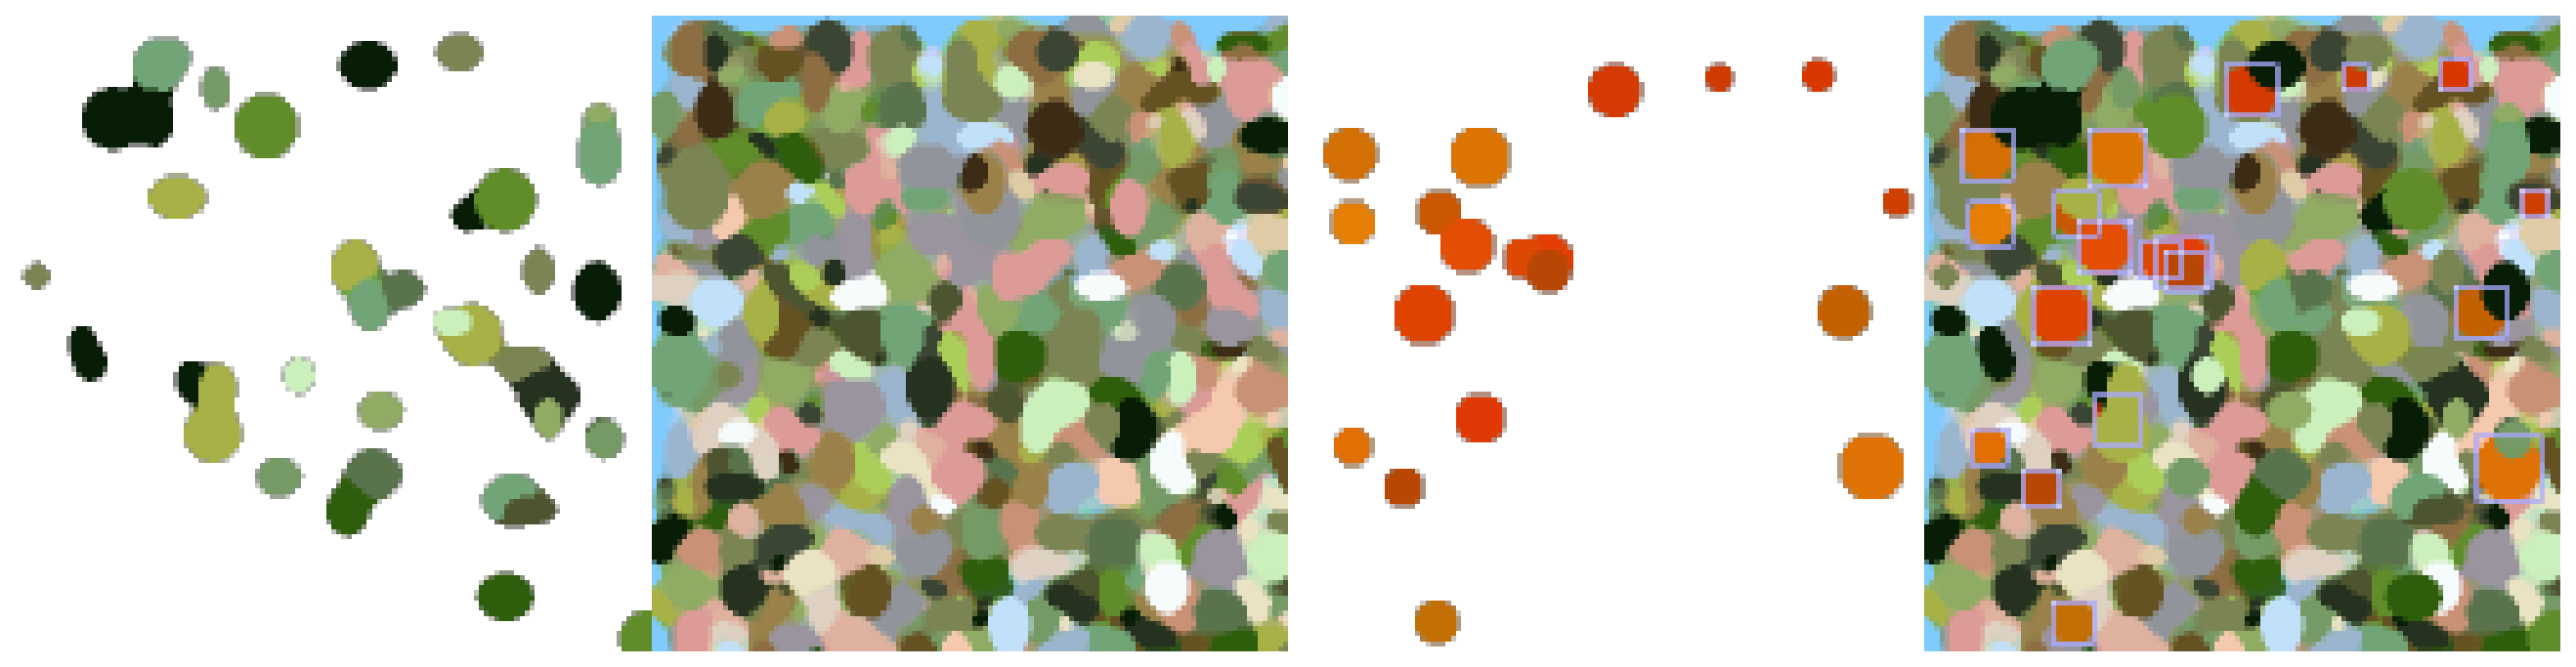

In [10]:
im_rect = np.array(im_combine)
for info in fruit_info:
    x1, y1, w, h, c = info
    x2, y2 = x1 + w, y1 + h
    cv2.rectangle(im_rect, (x1, y1), (x2, y2), (0, 0, 255))
show_image(np.hstack([np.array(im_fg), np.array(im_bg), np.array(im_fruit), np.array(im_rect)]), width=500)

## IFA梯子案例

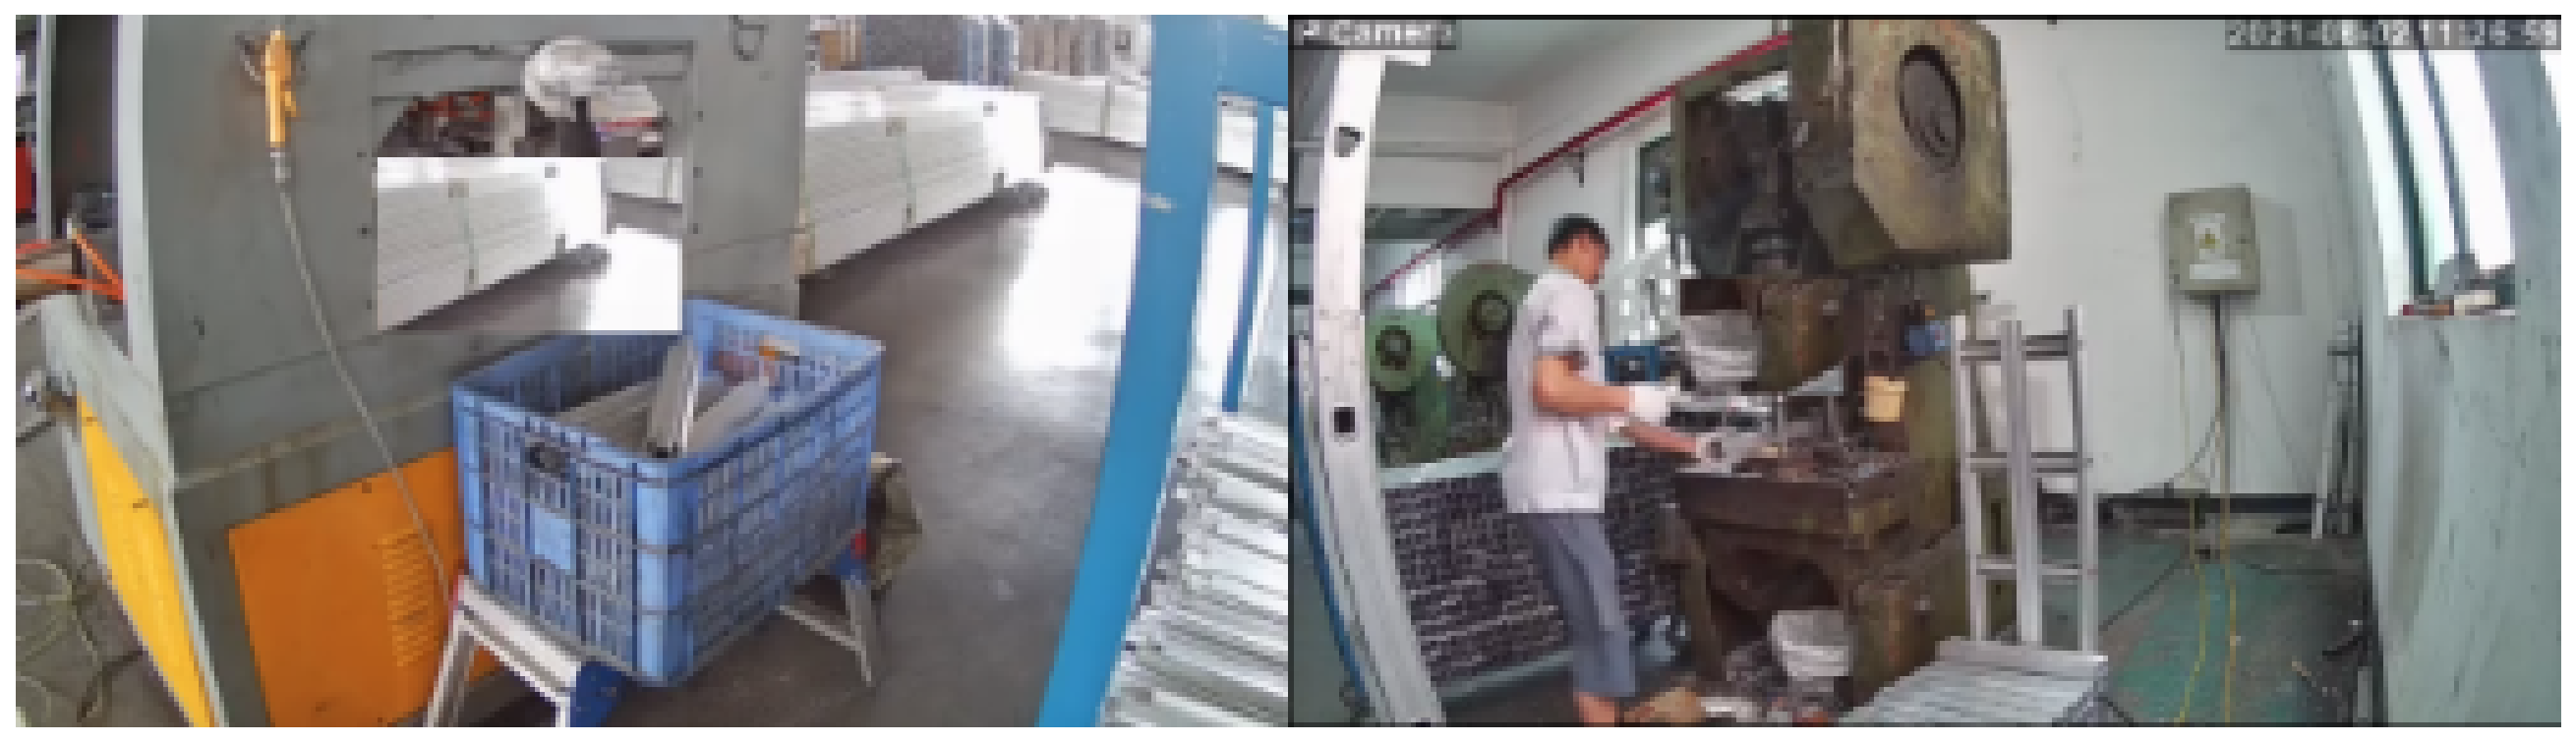

In [11]:
show_image(np.hstack([im_read('./bg_incise.png', size=(320, 180)), im_read('./bg_stiletto.png', size=(320, 180))]), width=500)

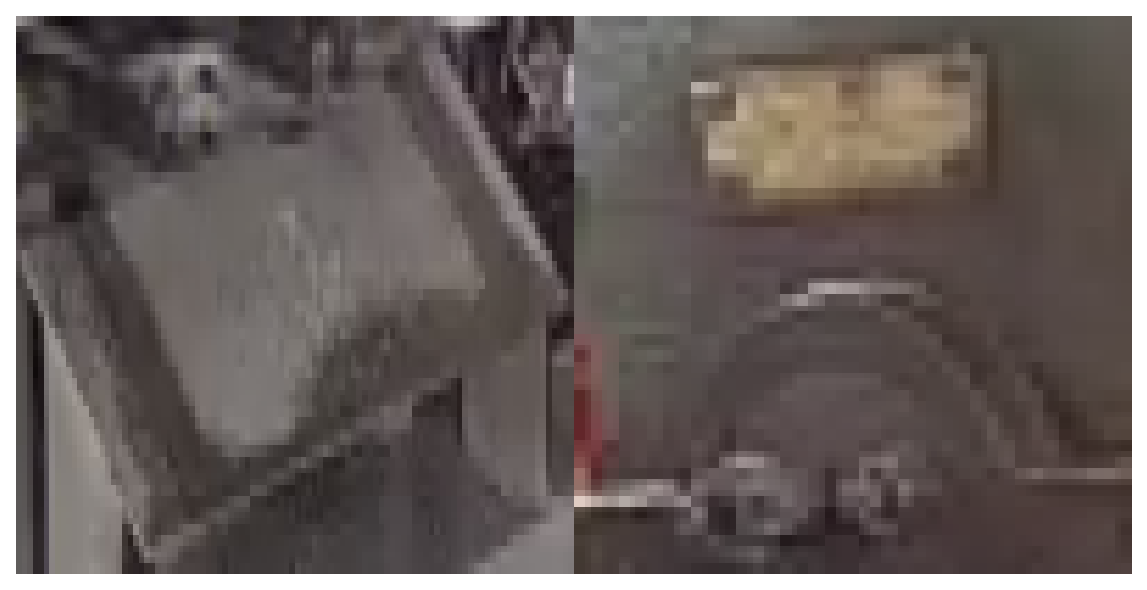

In [12]:
show_image(np.hstack([im_read('./incise.png', size=(100, 100)), im_read('./stiletto.png', size=(100, 100))]), width=200)

In [13]:
def rotation(image, angle):
    h, w = image.shape[:2]
    img_c = (w / 2, h / 2)

    rot = cv2.getRotationMatrix2D(img_c, angle, scale=1)

    rad = math.radians(angle)
    sin = math.sin(rad)
    cos = math.cos(rad)
    b_w = int((h * abs(sin)) + (w * abs(cos)))
    b_h = int((h * abs(cos)) + (w * abs(sin)))

    rot[0, 2] += ((b_w / 2) - img_c[0])
    rot[1, 2] += ((b_h / 2) - img_c[1])

    return cv2.warpAffine(image, rot, (b_w, b_h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_TRANSPARENT)

def resize(image, scale):
    h, w = image.shape[:2]
    return cv2.resize(image, (int(scale * w), int(scale * h)))

def blend_image_iter(bg_files, fg_files, fg_labels, tilesizes=[30], omaxnum=1, imgcount=100):
    bg_images = [cv2.imread(f) for f in bg_files]
    fg_images = [cv2.imread(f) for f in fg_files]
    
    tileposes = [
        [
            [
                (
                    int(0.5 * (img.shape[1] % tilesize)) + tilesize * x,
                    int(0.5 * (img.shape[0] % tilesize)) + tilesize * y
                )
                for x in range(int(img.shape[1] / tilesize)) for y in range(int(img.shape[0] / tilesize))
            ]
            for tilesize in tilesizes
        ]
        for img in bg_images
    ]
    
    for _ in range(imgcount):
        # bg
        choice = random.choice(range(len(bg_images)))
        bg_new = bg_images[choice].copy()
        if random.random() > 0.2:
            ts_choice = random.choice(range(len(tilesizes)))
            tilesize = tilesizes[ts_choice]
            tilepos_0 = tileposes[choice][ts_choice]
            tilepos_1 = tilepos_0.copy()
            random.shuffle(tilepos_1) 
            for (x0, y0), (x1, y1) in zip(tilepos_0, tilepos_1):
                bg_new[y0:y0 + tilesize, x0:x0 + tilesize] = bg_images[choice][y1:y1 + tilesize, x1:x1 + tilesize]
            bg_new = cv2.medianBlur(bg_new, ksize=7)
        
        # bg hsv
        if random.random() > 0.7:
            img_hsv = cv2.cvtColor(bg_new, cv2.COLOR_BGR2HSV)
            h,s,v = cv2.split(img_hsv)
            if random.random() > 0.2:
                v = np.clip(cv2.add(1 * v, 30), 0, 255)
            else:
                v = np.clip(cv2.add(2 * v, 20), 0, 255)
            img_hsv = np.uint8(cv2.merge((h,s,v)))
            bg_new = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2BGR)

        # fg
        labels = []
        annotations = []
        # for choice in random.choices(range(len(fg_images)), k=random.choice([1, 1, 1, 2])):
        for choice in random.choices(range(len(fg_images)), k=random.randint(1, omaxnum)):
            fgimg = fg_images[choice]
            fgimg = resize(fgimg, 0.9 + 1.1 * random.random())
            if random.random() > 0.8:
                fgimg = rotation(fgimg, -5 + 10 * random.random())
            fgx = random.randint(0, bg_new.shape[1] - fgimg.shape[1])
            fgy = random.randint(0, bg_new.shape[0] - fgimg.shape[0])
            bg_new[fgy:fgy + fgimg.shape[0], fgx:fgx + fgimg.shape[1]] = fgimg
            labels.append('%d %.6f %.6f %.6f %.6f' %(
                fg_labels[choice],
                (fgx + int(0.5 * fgimg.shape[1])) / bg_new.shape[1],
                (fgy + int(0.5 * fgimg.shape[0])) / bg_new.shape[0],
                fgimg.shape[1] / bg_new.shape[1], fgimg.shape[0] / bg_new.shape[0]
            ))
        bg_new = cv2.medianBlur(bg_new, ksize=3)
        yield bg_new, labels

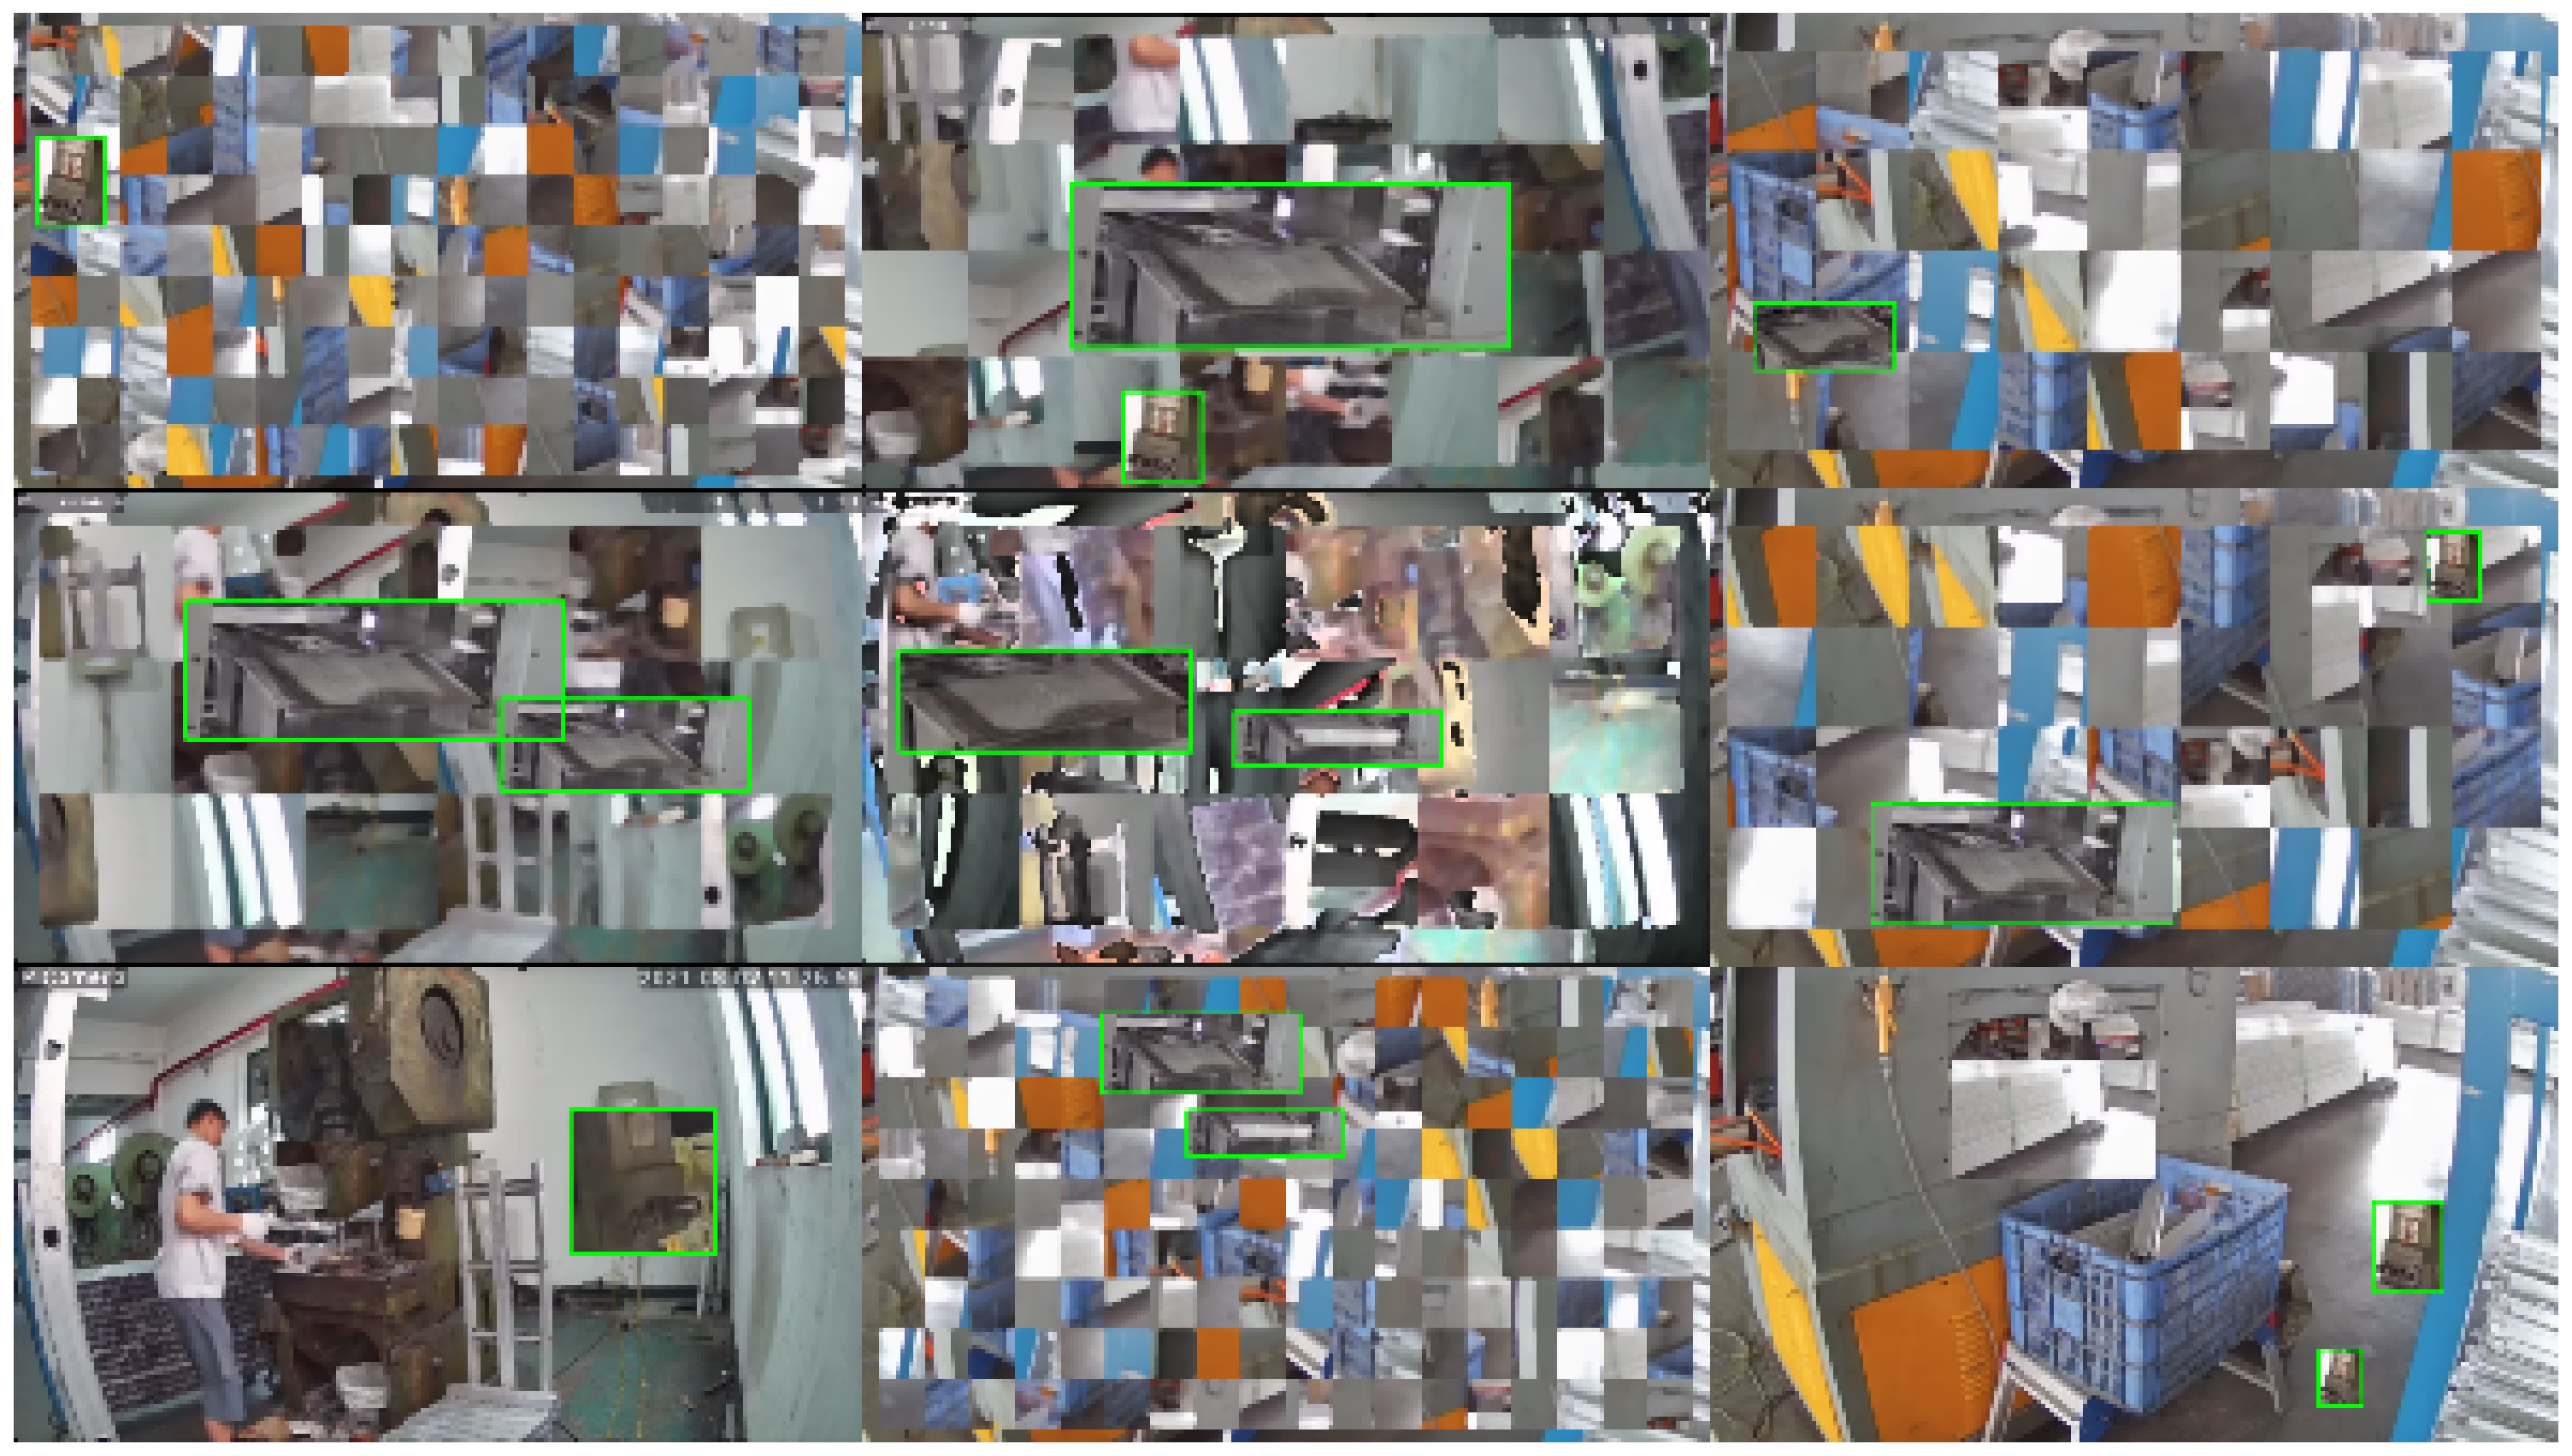

In [14]:
iter_blend = blend_image_iter(
    ['./bg_incise.png', './bg_stiletto.png'],
    ['./incise.png', './incise_1.png', './incise_2.png', './stiletto.png', './stiletto_1.png', './stiletto_2.png'],
    [0, 0, 0, 1, 1, 1],
    tilesizes=[50, 80, 100], omaxnum=2, imgcount=20)

images = []
for _ in range(9):
    image, labels = next(iter_blend)
    for ann in labels:
        rect = list(map(float, ann.split(' ')[1:]))
        x1, x2 = int(image.shape[1] * (rect[0] - 0.5 * rect[2])), int(image.shape[1] * (rect[0] + 0.5 * rect[2]))
        y1, y2 = int(image.shape[0] * (rect[1] - 0.5 * rect[3])), int(image.shape[0] * (rect[1] + 0.5 * rect[3]))
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), thickness=2)
    images.append(cv2.resize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), (640, 360)))
show_image(np.vstack((
    np.hstack(images[:3]),
    np.hstack(images[3:6]),
    np.hstack(images[6:]))
), width=600)

In [15]:
def create_yolov5_dataset(data_root, phase, fg_files, bg_files, fg_labels, tilesizes, omaxnum, count):
    images_path = f'{data_root}/images/{phase}'
    labels_path = f'{data_root}/labels/{phase}'
    if os.path.exists(images_path):
        os.system(f'rm -rf {images_path}')
    os.makedirs(images_path)
    if os.path.exists(labels_path):
        os.system(f'rm -rf {labels_path}')
    os.makedirs(labels_path)

    for i, (image, label) in enumerate(blend_image_iter(
        bg_files, fg_files,
        fg_labels, tilesizes=tilesizes,
        omaxnum=omaxnum, imgcount=count)):
        
        cv2.imwrite(f'{images_path}/{i}.png', image)
        with open(f'{labels_path}/{i}.txt', 'w') as fw:
            fw.write('\n'.join(label))

In [23]:
data_root = '/data/ladder'
bg_files = ['./ladder_foot/bg.png', './ladder_foot/bg2.png']
fg_files = [
    './ladder_foot/f1.png', './ladder_foot/f2.png', './ladder_foot/f3.png', './ladder_foot/f4.png', 
    './ladder_foot/f5.png', './ladder_foot/f6.png', './ladder_foot/f7.png', './ladder_foot/f8.png', 
    './ladder_foot/f9.png', './ladder_foot/f10.png',
]
fg_labels = [0] * 10

create_yolov5_dataset(data_root, 'train', fg_files, bg_files, fg_labels, tilesizes=[50, 90, 120], omaxnum=6, count=1000)
create_yolov5_dataset(data_root, 'val', fg_files, bg_files, fg_labels, tilesizes=[50, 90, 120], omaxnum=6, count=300)

In [19]:
data_root = '/data/ladder'
bg_files = ['./ladder_joint/bg.png']
fg_files = [
    './ladder_joint/j1.png', './ladder_joint/j2.png', './ladder_joint/j3.png',
    './ladder_joint/j4.png', './ladder_joint/j5.png', './ladder_joint/j6.png'
]
fg_labels = [0] * 6

create_yolov5_dataset(data_root, 'train', fg_files, bg_files, fg_labels, tilesizes=[60, 90, 120], omaxnum=6, count=1000)
create_yolov5_dataset(data_root, 'val', fg_files, bg_files, fg_labels, tilesizes=[60, 90, 120], omaxnum=6, count=300)

In [21]:
images = [im_read(f'{data_root}/images/train/{i}.png') for i in random.choices(range(1, 1000), k=9)]

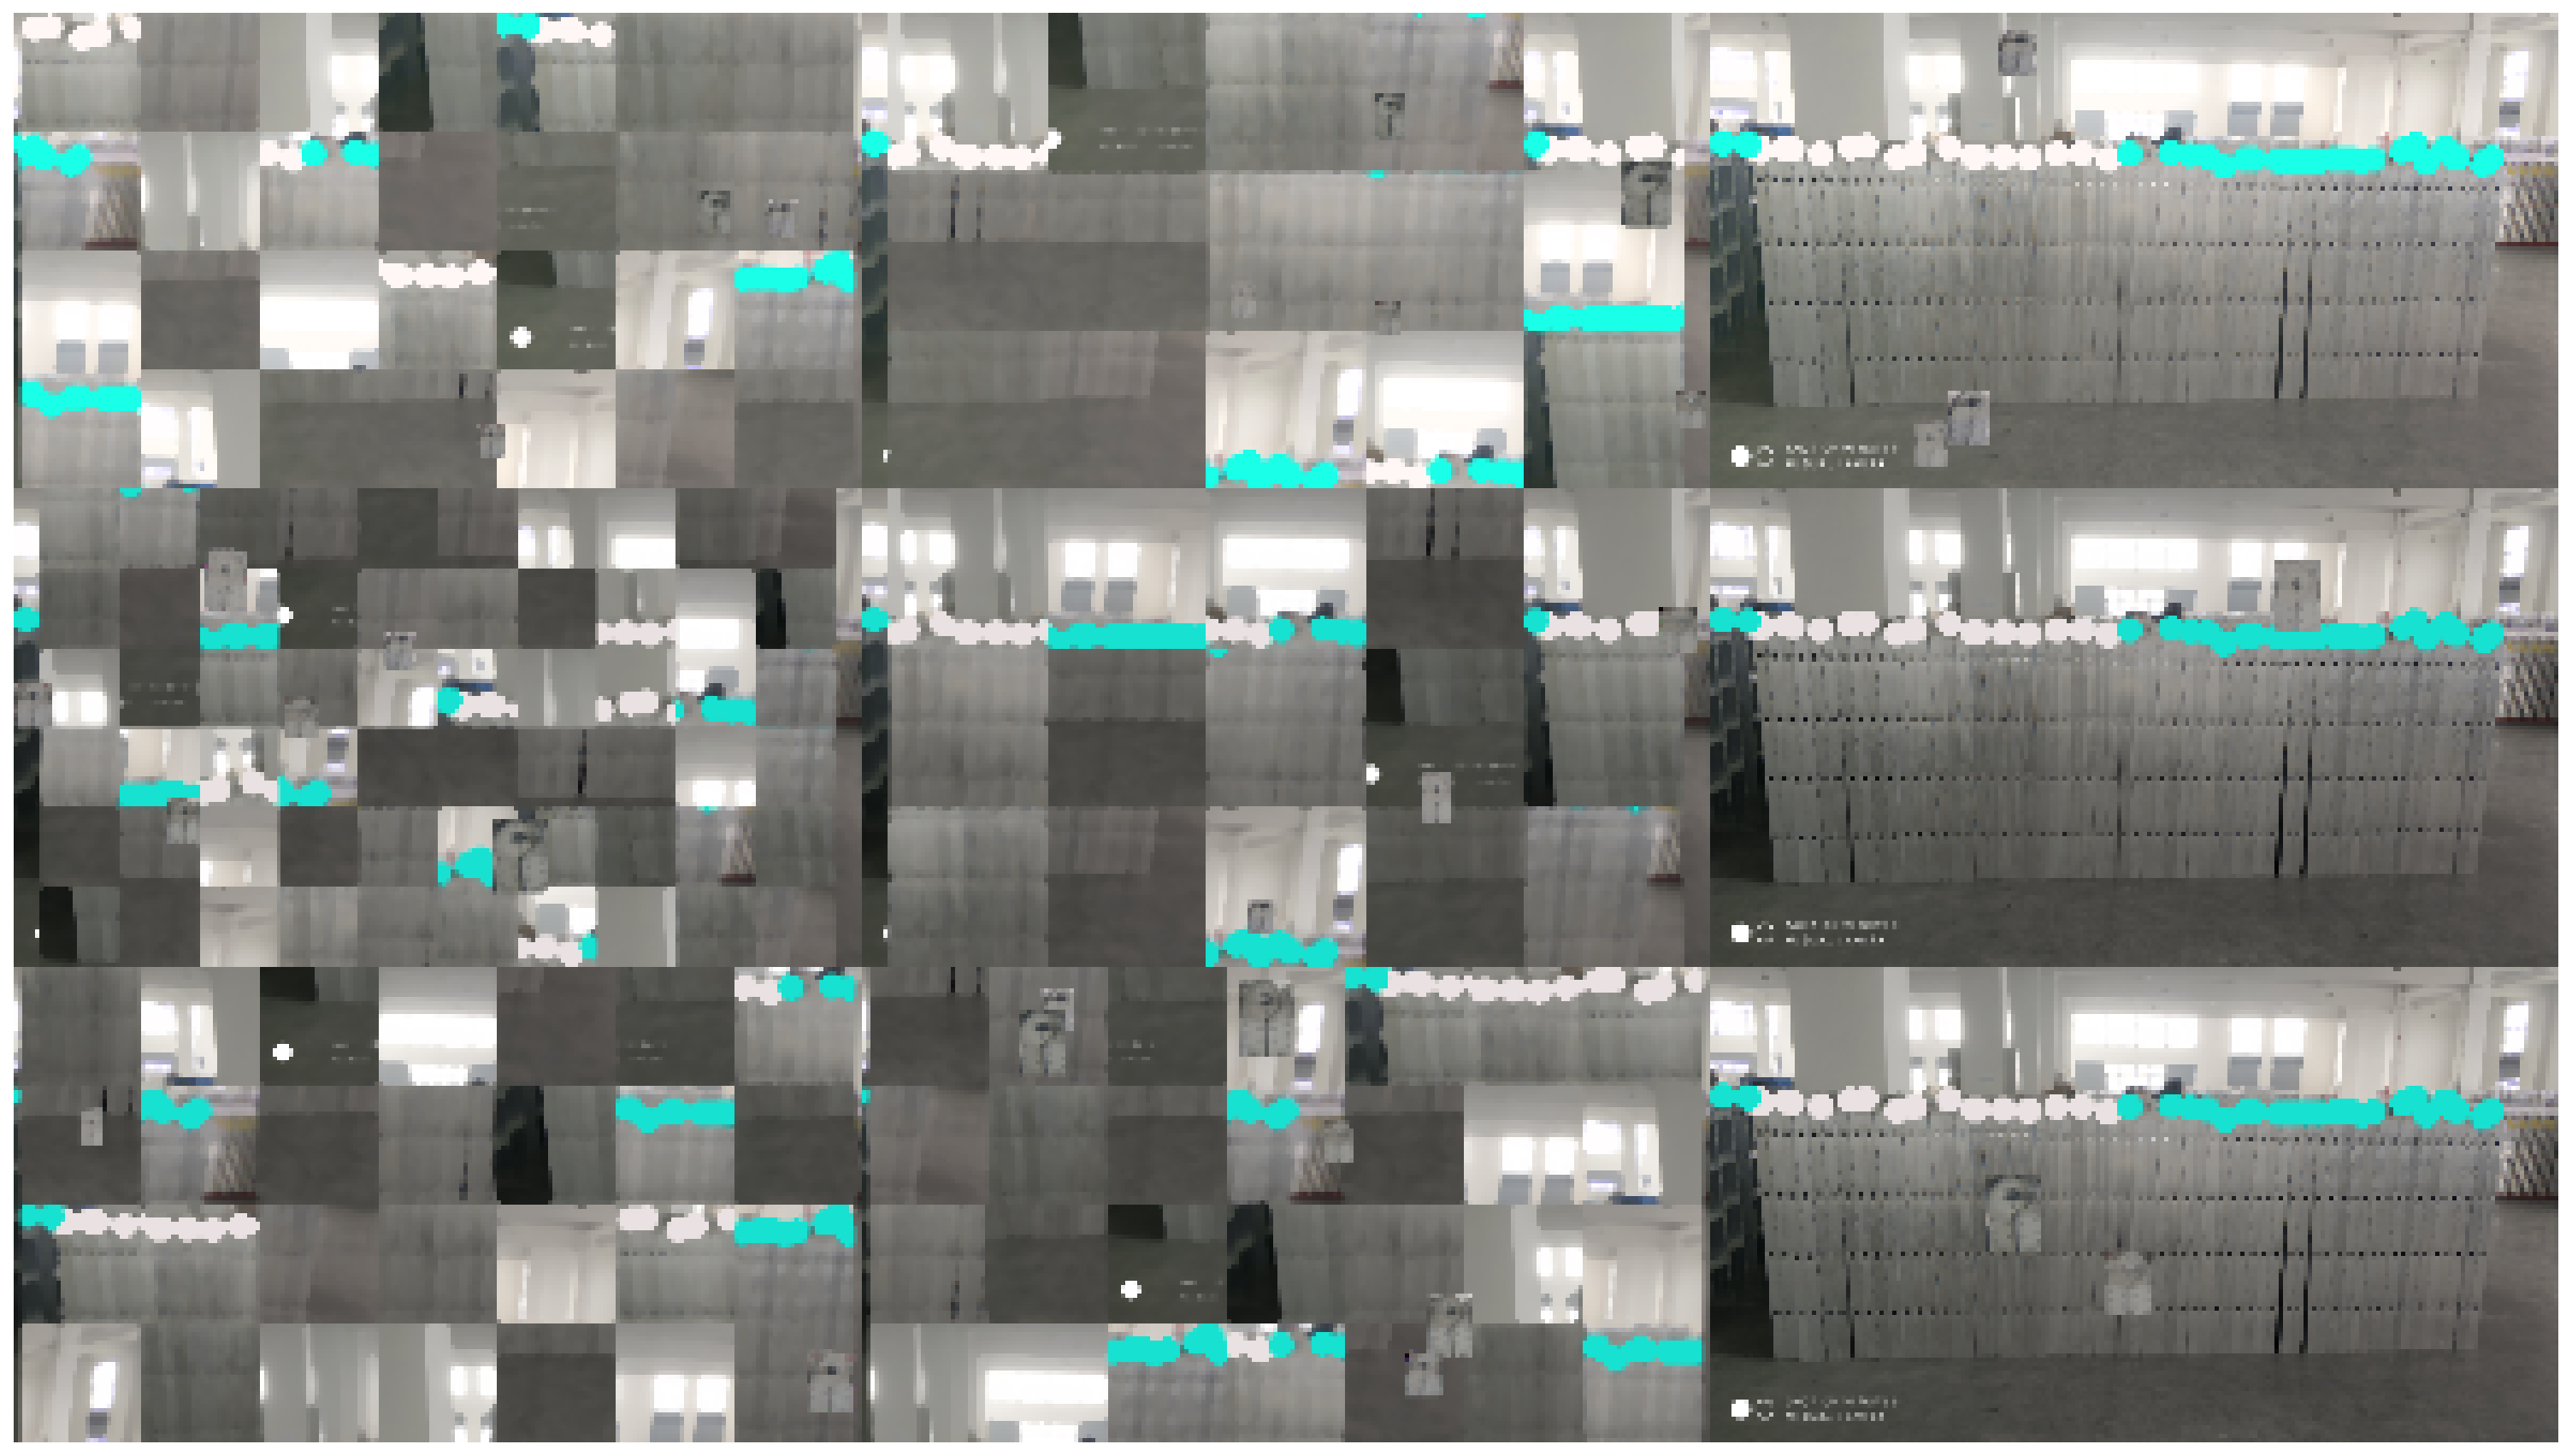

In [22]:
show_image(np.vstack((
    np.hstack(images[:3]),
    np.hstack(images[3:6]),
    np.hstack(images[6:]))
), width=600)

## References

1. https://towardsdatascience.com/creating-synthetic-data-for-machine-learning-dab5728f6411